In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [4]:
# creating engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflecting existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# Viewing all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Saving references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Creating our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Exploring database to access more information about tables
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [10]:
# Getting a list of column names and types for measurement table
columns_measurement = inspector.get_columns('measurement')
for c in columns_measurement:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Finding the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23',)

In [12]:
# Designing a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculating the date one year from the last date in data set.
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print("Query Date: ", query_date)

Query Date:  2016-08-23


In [13]:
# Performing a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
                        filter(Measurement.date >= query_date).all()

precipitation_data[:10]

[('2016-08-23', 0.0),
 ('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0),
 ('2016-08-28', 0.01),
 ('2016-08-29', 0.0),
 ('2016-08-30', 0.0),
 ('2016-08-31', 0.13),
 ('2016-09-01', 0.0)]

In [14]:
# Saving the query results as a Pandas DataFrame and setting the index to the date column
precipitation_df = pd.DataFrame(precipitation_data, columns=['date', 'precipitation'])
precipitation_df.set_index('date', inplace=True)
precipitation_df

,precipitation
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
...,...
2017-08-19,0.09
2017-08-20,NaN
2017-08-21,0.56


In [15]:
# Sorting the dataframe by date
precipitation_df = precipitation_df.sort_values('date')
precipitation_df

,precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


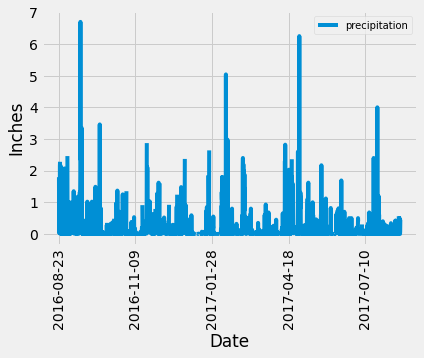

<Figure size 864x576 with 0 Axes>

In [16]:
# Using Pandas Plotting with Matplotlib to plot the data
ax = precipitation_df.plot()
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.legend(loc='upper right')
plt.legend(fontsize=10)
plt.figure(figsize=(12, 8))
plt.tight_layout()

# Saving graph to Images folder
ax.figure.savefig('Images/precipitaton.png', dpi=300, bbox_inches='tight')

# Displaying the plot
plt.show()

In [17]:
# Using Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [18]:
# Getting a list of column names and types for station table
columns_station = inspector.get_columns('station')
for c in columns_station:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [19]:
# Designing a query to calculate the total number stations in the dataset
total_count = session.query(Station.id).distinct().count()
print(total_count)

9


In [20]:
# Designing a query to find the most active stations (i.e. what stations have the most rows?)
# Listing the stations and the counts in descending order.
station_activity = session.query(Measurement.station, func.count(Measurement.station)).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).all()
station_activity


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [21]:
# Using the most active station id from the previous query to calculate the lowest, highest, and average temperature.

# Collecting most active station id
query_id = station_activity[0][0]
print(f'The id of the most active station is {query_id}')

# Calculating the lowest temperature
lowest_temp = session.query(func.min(Measurement.tobs)).\
                    filter(Measurement.station == query_id).scalar()
print(f'The lowest temperature at this station was {lowest_temp}')

# Calculating the highest temperature
highest_temp = session.query(func.max(Measurement.tobs)).\
                    filter(Measurement.station == query_id).scalar()
print(f'The highest temperature at this station was {highest_temp}')

# Calculating the average temperature
avg_temp = session.query(func.avg(Measurement.tobs)).\
                    filter(Measurement.station == query_id).scalar()
print(f'The average temperature at this station is {avg_temp}')

The id of the most active station is USC00519281
The lowest temperature at this station was 54.0
The highest temperature at this station was 85.0
The average temperature at this station is 71.66378066378067


In [22]:
# Using most active station ID to collect last 12 months of temperature observation data to plot as histogram
temperature_data = session.query(Measurement.tobs).\
                        filter(Measurement.date >= query_date).\
                        filter(Measurement.station == query_id).all()

temperature_data[:10]

[(77.0,),
 (77.0,),
 (80.0,),
 (80.0,),
 (75.0,),
 (73.0,),
 (78.0,),
 (77.0,),
 (78.0,),
 (80.0,)]

In [23]:
# Creating data frame from temperature data
temperature_df = pd.DataFrame(temperature_data, columns=['tobs'])
temperature_df

,tobs
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0
...,...
347,77.0
348,77.0
349,76.0
350,76.0


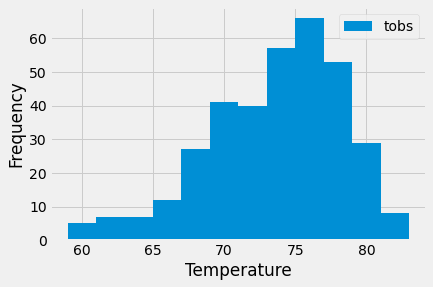

<Figure size 864x576 with 0 Axes>

In [35]:
# Plotting histogram from data frame
ax2 = temperature_df.plot(kind='hist', bins=12)
plt.figure(figsize=(12, 8))
ax2.set_xlabel('Temperature')
plt.tight_layout()

# Saving graph to Images folder
ax2.figure.savefig('Images/temperature.png', dpi=300, bbox_inches='tight')

# Displaying the plot
plt.show()

# Close session

In [25]:
# Close Session
session.close()